# 数据加载+预处理

In [2]:
# Code Block 1: Data Loading and Preprocessing
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load and preprocess the dataset
file_path = r'F:\8--BJTU大三\大三下\商务智能 选修\团队作业\ubaar-competition\train50k_processed.csv'
df = pd.read_csv(file_path)
df = df.iloc[:5000]

# Handle outliers in the 'price' column
q99 = df['price'].quantile(0.99)
df = df[df['price'] <= q99]

# Split the data
X = df.drop(columns=['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Use a smaller subset for SHAP calculations （改这里防止挂内核）
shap_sample_size = 100
X_test_sample = X_test.iloc[:shap_sample_size]

# 所有模型一起跑SHAP+Mean Shap value（除Ada）

In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error

def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    # Calculate SHAP values
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    
    # Output results
    print(f'\n{model_name} Model')
    print(f'R^2 Score: {r2}')
    print(f'MAPE: {mape}')
    
    # SHAP summary plot
    plt.figure(figsize=(10, 6), dpi=300)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f'SHAP Summary Plot for {model_name} Model')
#     plt.savefig(f'shap_summary_{model_name.lower()}.png', dpi=300, transparent=True)
    plt.show()
    
    # Calculate mean SHAP values for each feature
    mean_shap_values = shap_values.abs.mean(0).values
    feature_names = X_test.columns
    
    # Create a DataFrame with feature names and mean SHAP values
    shap_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean SHAP Value': mean_shap_values,
        'Model': model_name
    })
    
    return shap_df

# Define models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
#     'AdaBoost': AdaBoostRegressor(random_state=42)
}

# Initialize an empty DataFrame to hold all results
all_shap_df = pd.DataFrame()

# Train and evaluate each model, and collect results
for model_name, model in models.items():
    shap_df = train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test)
    all_shap_df = pd.concat([all_shap_df, shap_df], ignore_index=True)

# Save the combined DataFrame to an Excel file
all_shap_df.to_excel('all_shap_mean_values.xlsx', index=False)

# Print the combined DataFrame
print(all_shap_df)


# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# Train and evaluate AdaBoost model
ada_model = AdaBoostRegressor(random_state=42)
ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_test)
r2_ada = r2_score(y_test, y_pred_ada)
mape_ada = mean_absolute_percentage_error(y_test, y_pred_ada)

# SHAP values calculation for AdaBoost using KernelExplainer
subset_size = 100
X_train_subset = X_train[:subset_size]
X_test_subset = X_test[:subset_size]

explainer_ada = shap.KernelExplainer(ada_model.predict, X_train_subset)  # using a small subset of training data
shap_values_ada = explainer_ada.shap_values(X_test_subset)  # using a small subset of test data

# Output results for AdaBoost
print('\nAdaBoost Model')
print(f'R^2 Score: {r2_ada}')
print(f'MAPE: {mape_ada}')

# Create the summary plot with specified requirements
plt.figure(figsize=(10, 6), dpi=300)
shap.summary_plot(shap_values_ada, X_test_subset, show=False)
plt.title('AdaBoost Model SHAP Summary Plot')
plt.savefig('adaboost_shap_summary.png', dpi=300, transparent=True)
plt.show()

# Calculate mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values_ada).mean(axis=0)
feature_names = X_test.columns

# Create a DataFrame for the SHAP values
shap_df = pd.DataFrame(list(zip(feature_names, mean_shap_values)), columns=['Feature', 'Mean SHAP Value'])
shap_df = shap_df.sort_values(by='Mean SHAP Value', ascending=False)

# Print the sorted mean SHAP values
print(shap_df)

# Save the DataFrame to an Excel file
shap_df.to_excel('adaboost_shap_values.xlsx', index=False)


# 拓展分析

 98%|===================| 970/990 [00:35<00:00]        

RandomForest Model
R^2 Score: 0.7981604958818471
MAPE: 0.24673005899341977


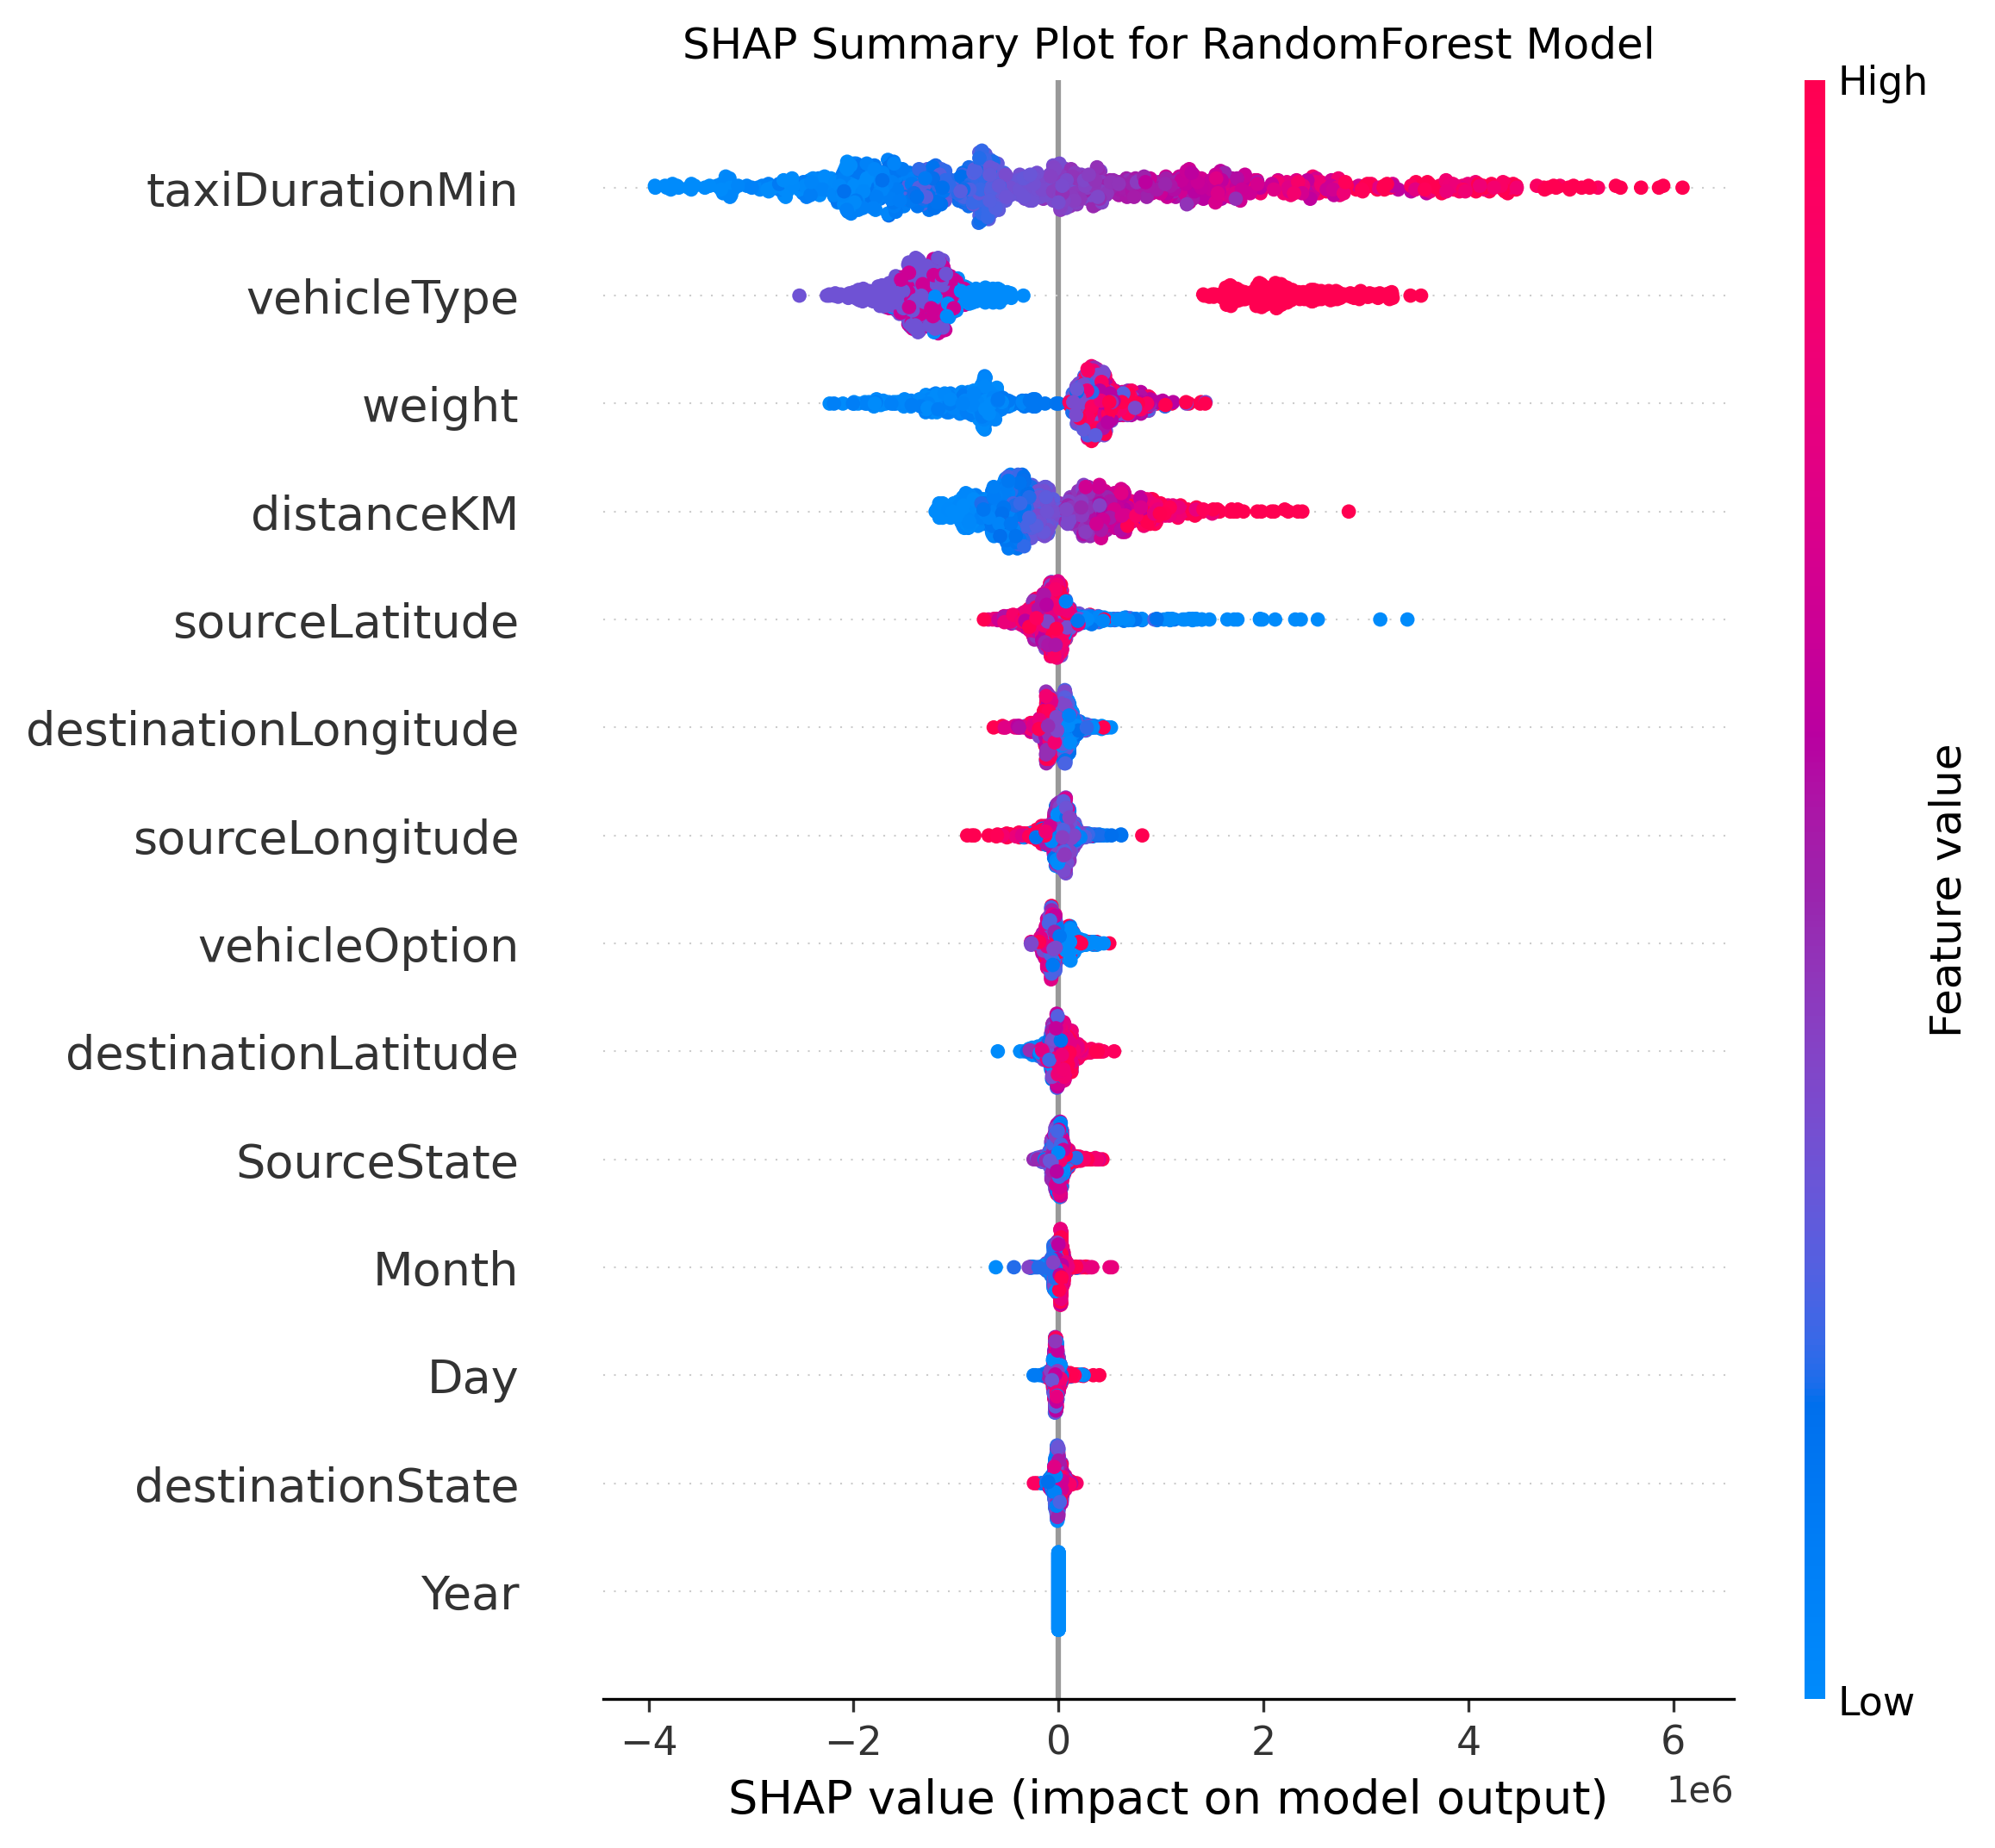

In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# 假设已经有X_train, y_train, X_test, y_test数据集

def train_and_evaluate_rf_model(X_train, y_train, X_test, y_test):
    # 定义和训练随机森林模型
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)
    
    # 预测和评估
    y_pred = rf_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    # 计算SHAP值
    explainer = shap.Explainer(rf_model, X_train)
    shap_values = explainer(X_test)
    
    # 输出结果
    print(f'RandomForest Model')
    print(f'R^2 Score: {r2}')
    print(f'MAPE: {mape}')
    
    # SHAP汇总图
    plt.figure(figsize=(10, 6), dpi=300)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title('SHAP Summary Plot for RandomForest Model')
    plt.show()
    
    # 计算每个特征的平均SHAP值
    mean_shap_values = shap_values.abs.mean(0).values
    feature_names = X_test.columns
    
    # 创建包含特征名称和平均SHAP值的数据框
    shap_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean SHAP Value': mean_shap_values,
        'Model': 'RandomForest'
    })
    
    return shap_df, explainer, shap_values, rf_model

# 训练和评估模型，并收集结果
shap_df, rf_explainer, rf_shap_values, rf_model = train_and_evaluate_rf_model(X_train, y_train, X_test, y_test)

# 保存结果到Excel文件
shap_df.to_excel('rf_shap_mean_values.xlsx', index=False)

# 打印数据框
print(shap_df)

# SHAP交互图
plt.figure(figsize=(10, 6), dpi=300)
shap_interaction_values = shap.TreeExplainer(rf_model).shap_interaction_values(X_test)
shap.summary_plot(shap_interaction_values, X_test, plot_type="dot", show=False)
plt.title('SHAP Interaction Plot for RandomForest Model')
plt.show()

# SHAP单样本图
sample_idx_1 = 0  # 第一个样本的索引
shap.force_plot(rf_explainer.expected_value, rf_shap_values[sample_idx_1], X_test.iloc[sample_idx_1, :], matplotlib=True)

sample_idx_2 = 1  # 第二个样本的索引
shap.force_plot(rf_explainer.expected_value, rf_shap_values[sample_idx_2], X_test.iloc[sample_idx_2, :], matplotlib=True)
